# Introduction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gc
import time
from contextlib import contextmanager

from itertools import product

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import shap

import warnings
warnings.filterwarnings("ignore")

In [2]:
@contextmanager
def timer(title, p = 3) :
    start_time = time.time()
    yield
    duration = round(time.time() - start_time, p)
    print(title, ":", duration, "seconde(s)")

In [3]:
with timer("Temps de chargement des données :") :
    app_train = pd.read_csv("csv/preprocessed/app_train.csv")
    app_test = pd.read_csv("csv/preprocessed/app_test.csv")

print("Dimensions du jeu d'entraînement", app_train.shape)
print("Dimensions du jeu de test", app_test.shape)

Temps de chargement des données : : 15.505 seconde(s)
Dimensions du jeu d'entraînement (246005, 772)
Dimensions du jeu de test (61502, 772)


In [4]:
def rge_score(labels, binary_preds, credit_amounts, interest_ratio = 0.1) :
    
    expected_gain = 0
    effective_gain = 0
    
    for label, pred, credit_amount in zip(labels, binary_preds, credit_amounts) :
        if label == 0 :
            expected_gain += interest_ratio * credit_amount
            if pred == 0 :
                effective_gain += interest_ratio * credit_amount
        if label == 1 and pred == 0 :
            effective_gain -= credit_amount
            
    return effective_gain / expected_gain

In [5]:
X_train = app_train.drop(columns = ["TARGET", "SK_ID_CURR"])
X_test = app_test.drop(columns = ["TARGET", "SK_ID_CURR"])
y_train = app_train["TARGET"]
y_test = app_test["TARGET"]

for strategy in ["uniform", "stratified", "most_frequent"] :
    dummy = DummyClassifier(strategy = strategy)
    dummy.fit(X_train, y_train)
    preds = dummy.predict(X_test)
    rge = rge_score(y_test, preds, X_test["AMT_CREDIT"])
    print(f"Score RGE du {strategy} dummy classifier sur le jeu de test : {round(rge, 5)}")
    
del X_train, X_test, y_train, y_test, dummy, preds

Score RGE du uniform dummy classifier sur le jeu de test : 0.07818
Score RGE du stratified dummy classifier sur le jeu de test : 0.17561
Score RGE du most_frequent dummy classifier sur le jeu de test : 0.18866


# Premier modèle

In [6]:
def preprocess_data(df_train, df_test, selected_features) :
    
    # Extraction des colonnes
    data = {
        "X_train" : df_train[selected_features].copy(),
        "X_test" : df_test[selected_features].copy(),
        "y_train" : df_train["TARGET"].copy(),
        "y_test" : df_test["TARGET"].copy(),
        "amt_train" : df_train["AMT_CREDIT"].copy(),
        "amt_test" : df_test["AMT_CREDIT"].copy()
    }
    
    # Abandon des colonnes n'ayant qu'une seule valeur
    columns_to_drop = data["X_train"].columns[data["X_train"].nunique() == 1]
    X_train_cleaned = data["X_train"].drop(columns = columns_to_drop)
    X_test_cleaned = data["X_test"].drop(columns = columns_to_drop)
    
    # Imputation des valeurs manquantes par la médiane
    imputer = SimpleImputer(strategy = "median")
    X_train_imputed = imputer.fit_transform(X_train_cleaned)
    X_test_imputed = imputer.transform(X_test_cleaned)
    
    # Normalisation des valeurs
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)
    
    # Réattribution des noms des colonnes
    data["X_train"] = pd.DataFrame(X_train_scaled, columns = X_train_cleaned.columns)
    data["X_test"] = pd.DataFrame(X_test_scaled, columns = X_test_cleaned.columns)
    
    return data

In [7]:
selected_features = [col for col in app_train.columns if col not in ["SK_ID_CURR", "TARGET"]]

with timer("Temps de prétraitement") :
    processed_data = preprocess_data(app_train, app_test, selected_features)
    
for name, df in processed_data.items() :
    print(name, ":", df.shape)

Temps de prétraitement : 29.942 seconde(s)
X_train : (246005, 763)
X_test : (61502, 763)
y_train : (246005,)
y_test : (61502,)
amt_train : (246005,)
amt_test : (61502,)


In [8]:
baseline = LogisticRegression()
baseline.fit(processed_data["X_train"], processed_data["y_train"])

preds_train = baseline.predict(processed_data["X_train"])
preds_test = baseline.predict(processed_data["X_test"])

rge_train = rge_score(processed_data["y_train"], preds_train, processed_data["amt_train"])
rge_test = rge_score(processed_data["y_test"], preds_test, processed_data["amt_test"])

print("--- Baseline (LogisticRegression) ---")
print(f"Score RGE sur le jeu d'entraînement : {round(rge_train, 5)}")
print(f"Score RGE sur le jeu de test : {round(rge_test, 5)}")

--- Baseline (LogisticRegression) ---
Score RGE sur le jeu d'entraînement : 0.2048
Score RGE sur le jeu de test : 0.20727


In [9]:
proba_preds_train = baseline.predict_proba(processed_data["X_train"])[:, 1]
proba_preds_test = baseline.predict_proba(processed_data["X_test"])[:, 1]

binary_preds_train = (proba_preds_train >= 0.5).astype(int)
binary_preds_test = (proba_preds_test >= 0.5).astype(int)

rge_train = rge_score(processed_data["y_train"], binary_preds_train, processed_data["amt_train"])
rge_test = rge_score(processed_data["y_test"], binary_preds_test, processed_data["amt_test"])

print("--- LogisticRegression ---")
print("Seuil d'acceptation : 0.5")
print(f"Score RGE sur le jeu d'entraînement : {round(rge_train, 5)}")
print(f"Score RGE sur le jeu de test : {round(rge_test, 5)}")

--- LogisticRegression ---
Seuil d'acceptation : 0.5
Score RGE sur le jeu d'entraînement : 0.2048
Score RGE sur le jeu de test : 0.20727


In [10]:
binary_preds_train = (proba_preds_train >= 0.2).astype(int)
binary_preds_test = (proba_preds_test >= 0.2).astype(int)

rge_train = rge_score(processed_data["y_train"], binary_preds_train, processed_data["amt_train"])
rge_test = rge_score(processed_data["y_test"], binary_preds_test, processed_data["amt_test"])

print("--- LogisticRegression ---")
print("Seuil d'acceptation : 0.2")
print(f"Score RGE sur le jeu d'entraînement : {round(rge_train, 5)}")
print(f"Score RGE sur le jeu de test : {round(rge_test, 5)}")

--- LogisticRegression ---
Seuil d'acceptation : 0.2
Score RGE sur le jeu d'entraînement : 0.3611
Score RGE sur le jeu de test : 0.36166


# Optimisation du seuil d'acceptation

In [11]:
def get_rge_by_acceptance(labels, proba_preds, credit_amounts) :
    
    acceptance_values = np.linspace(0, 1, 100)
    rge_values = []
    
    for acceptance in acceptance_values :
        binary_preds = (proba_preds >= acceptance).astype(int)
        rge = rge_score(labels, binary_preds, credit_amounts)
        rge_values.append(rge)
    
    return acceptance_values, rge_values

In [12]:
def plot_rge_by_acceptance(acceptance_values, rge_values) :
    
    plt.figure(figsize = (5, 3))
    plt.plot(acceptance_values, rge_values)
    
    plt.xlabel("Seuil d'acceptation")
    plt.ylabel(f"Score RGE")
    plt.title("Score RGE par seuil d'acceptation")
    plt.grid(True)
    
    plt.show()

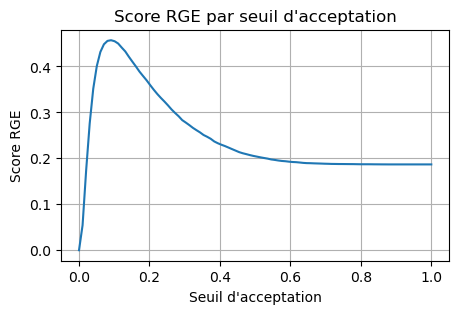

In [13]:
acceptance_values, rge_values = get_rge_by_acceptance(
    labels = processed_data["y_train"],
    proba_preds = proba_preds_train,
    credit_amounts = processed_data["amt_train"]
)

plot_rge_by_acceptance(acceptance_values, rge_values)

del baseline, preds_train, preds_test, proba_preds_train, proba_preds_test,
del binary_preds_train, binary_preds_test, acceptance_values, rge_values

In [14]:
def apply_classifier(data, classifier) :

    classifier.fit(data["X_train"], data["y_train"])

    preds = {"proba_train" : classifier.predict_proba(data["X_train"])[:, 1],
             "proba_test" : classifier.predict_proba(data["X_test"])[:, 1]}

    acceptance_values, rge_values = get_rge_by_acceptance(data["y_train"], preds["proba_train"], data["amt_train"])
    preds["acceptance_curve"] = (acceptance_values, rge_values)
    preds["acceptance"] = acceptance_values[np.argmax(rge_values)]
    
    preds["binary_train"] = (preds["proba_train"] >= preds["acceptance"]).astype(int)
    preds["binary_test"] = (preds["proba_test"] >= preds["acceptance"]).astype(int)

    return preds

In [15]:
def evaluate_preds(data, preds, display_results = True, display_curve = False) :
    
    rge_train = rge_score(data["y_train"], preds["binary_train"], data["amt_train"])
    rge_test = rge_score(data["y_test"], preds["binary_test"], data["amt_test"])
    
    if display_results :
        print("Seuil d'acceptation :", round(preds["acceptance"], 2))
        print(f"Score RGE sur le jeu d'entraînement : {round(rge_train, 5)}")
        print(f"Score RGE sur le jeu de test : {round(rge_test, 5)}")
    
    if display_curve :
        acceptance_values, rge_values = preds["acceptance_curve"]
        plot_rge_by_acceptance(acceptance_values, rge_values)
        
    return rge_train, rge_test

In [16]:
preds = apply_classifier(processed_data, LogisticRegression())

print("--- LogisticRegression ---")
rge_train, rge_test = evaluate_preds(processed_data, preds)

--- LogisticRegression ---
Seuil d'acceptation : 0.09
Score RGE sur le jeu d'entraînement : 0.45721
Score RGE sur le jeu de test : 0.46114


# Méthodes d'équilibrage

In [17]:
def balance_sample(X_train, y_train, strategy) :

    if strategy == "over" :
        oversampler = RandomOverSampler(random_state = 42)
        return oversampler.fit_resample(X_train, y_train)
    
    if strategy == "under" :
        undersampler = RandomUnderSampler(random_state = 42)
        return undersampler.fit_resample(X_train, y_train)
    
    if strategy == "smote" :
        smote = SMOTE(random_state = 42)
        return smote.fit_resample(X_train, y_train)

In [18]:
def preprocess_with_balancing(X_train, X_test, y_train, y_test, strategy) :
    
    # Dictionnaire pour stocker les données traitées
    data = {"y_test" : y_test.copy()}
    
    # Imputation des valeurs manquantes (avec réattribution des noms des colonnes)
    imputer = SimpleImputer(strategy = "median")
    X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns = X_train.columns)
    X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns = X_test.columns)
    
    # Application de la méthode d'équilibrage
    X_train_balanced, data["y_train"] = balance_sample(X_train_imputed, y_train, strategy)
    
    # Abandon des colonnes n'ayant qu'une seule valeur
    columns_to_drop = X_train_balanced.columns[X_train_balanced.nunique() == 1]
    X_train_cleaned = X_train_balanced.drop(columns = columns_to_drop)
    X_test_cleaned = X_test_imputed.drop(columns = columns_to_drop)
    
    # Copie de AMT_CREDIT avant la normalisation (pour le RGE)
    data["amt_train"] = X_train_cleaned["AMT_CREDIT"].copy()
    data["amt_test"] = X_test_cleaned["AMT_CREDIT"].copy()
    
    # Normalisation des valeurs (avec réattribution des noms des colonnes)
    scaler = MinMaxScaler()
    data["X_train"] = pd.DataFrame(scaler.fit_transform(X_train_cleaned), columns = X_train_cleaned.columns)
    data["X_test"] = pd.DataFrame(scaler.transform(X_test_cleaned), columns = X_test_cleaned.columns)
    
    return data

In [19]:
gc.collect()

X_train = app_train.drop(columns = ["TARGET", "SK_ID_CURR"])
X_test = app_test.drop(columns = ["TARGET", "SK_ID_CURR"])
y_train = app_train["TARGET"]
y_test = app_test["TARGET"]

print("--- Oversampling ---")
with timer("Temps de traitement") :
    data_over = preprocess_with_balancing(X_train, X_test, y_train, y_test, strategy = "over")
    
for name, df in data_over.items() :
    print(name, ":", df.shape)
    
print("\n--- Undersampling ---")
with timer("Temps de traitement (undersampling)") :
    data_under = preprocess_with_balancing(X_train, X_test, y_train, y_test, strategy = "under")
    
for name, df in data_under.items() :
    print(name, ":", df.shape)

print("\n--- SMOTE ---")
with timer("Temps de traitement (SMOTE)") :
    data_smote = preprocess_with_balancing(X_train, X_test, y_train, y_test, strategy = "under")
    
for name, df in data_smote.items() :
    print(name, ":", df.shape)

del X_train, X_test, y_train, y_test

--- Oversampling ---
Temps de traitement : 44.001 seconde(s)
y_test : (61502,)
y_train : (452290,)
amt_train : (452290,)
amt_test : (61502,)
X_train : (452290, 763)
X_test : (61502, 763)

--- Undersampling ---
Temps de traitement (undersampling) : 27.1 seconde(s)
y_test : (61502,)
y_train : (39720,)
amt_train : (39720,)
amt_test : (61502,)
X_train : (39720, 749)
X_test : (61502, 749)

--- SMOTE ---
Temps de traitement (SMOTE) : 24.006 seconde(s)
y_test : (61502,)
y_train : (39720,)
amt_train : (39720,)
amt_test : (61502,)
X_train : (39720, 749)
X_test : (61502, 749)


In [24]:
gc.collect()

data_selector = {
    "oversampling" : data_over,
    "undersampling" : data_under,
    "SMOTE" : data_smote,
}

for (data_name, data) in data_selector.items() :
    print(f"\n--- LogisticRegression ({data_name}) ---")
    preds = apply_classifier(data, LogisticRegression())
    rge_train, rge_test = evaluate_preds(data, preds)


--- LogisticRegression (oversampling) ---
Seuil d'acceptation : 0.06
Score RGE sur le jeu d'entraînement : 0.00657
Score RGE sur le jeu de test : 0.01741

--- LogisticRegression (undersampling) ---
Seuil d'acceptation : 0.08
Score RGE sur le jeu d'entraînement : 0.01231
Score RGE sur le jeu de test : 0.03141

--- LogisticRegression (SMOTE) ---
Seuil d'acceptation : 0.08
Score RGE sur le jeu d'entraînement : 0.01231
Score RGE sur le jeu de test : 0.03141


# RandomForest et LightGBM

In [25]:
random_forest_params = {
    "n_estimators" : 100,
    "max_depth" : 10,
    "min_samples_split" : 2,
    "min_samples_leaf" : 1,
    "max_features" : 5,
    "bootstrap" : True,
    "random_state" : 42
}

rf_clf = RandomForestClassifier(**random_forest_params)

Seuil d'acceptation : 0.09
Score RGE sur le jeu d'entraînement : 0.51167
Score RGE sur le jeu de test : 0.39885


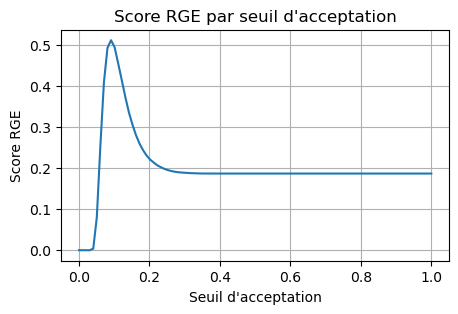

In [26]:
preds = apply_classifier(processed_data, rf_clf)
rge_train, rge_test = evaluate_preds(processed_data, preds, display_curve = True)

In [27]:
lgbm_params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "num_leaves" : 30,
    "learning_rate" : 0.05,
    "feature_fraction" : 0.9,
    "bagging_fraction" : 0.8, 
    "bagging_freq" : 5,
    "n_estimators" : 100,
    "verbose" : -1,
    "random_state" : 42
}

lgbm_clf = LGBMClassifier(**lgbm_params)

Seuil d'acceptation : 0.09
Score RGE sur le jeu d'entraînement : 0.50533
Score RGE sur le jeu de test : 0.47699


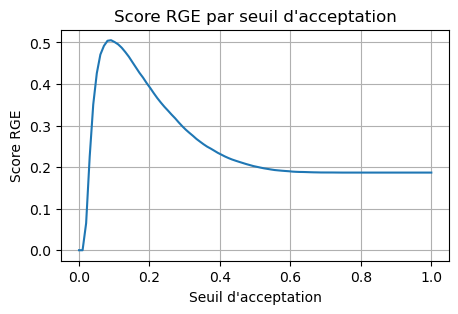

In [28]:
preds = apply_classifier(processed_data, lgbm_clf)
rge_train, rge_test = evaluate_preds(processed_data, preds, display_curve = True)

# Importance des features

In [29]:
def plot_feature_importances(df, max_display, title) :
    
    df = df.sort_values("importance", ascending = False).reset_index()
    df["importance_normalized"] = df["importance"] / df["importance"].sum()

    plt.figure(figsize = (6, 4))
    ax = plt.subplot()
    
    ax.barh(list(reversed(list(df.index[:max_display]))), 
            df["importance_normalized"].head(max_display), 
            align = "center",
            edgecolor = "k")
    
    ax.set_yticks(list(reversed(list(df.index[:max_display]))))
    ax.set_yticklabels(df["feature"].head(max_display))
    ax.tick_params(axis = "y", labelsize = 8)
    
    plt.xlabel("Importance normalisée")
    plt.title(title, size = 14)
    plt.show()
    
    return df.drop(columns = ["index"])

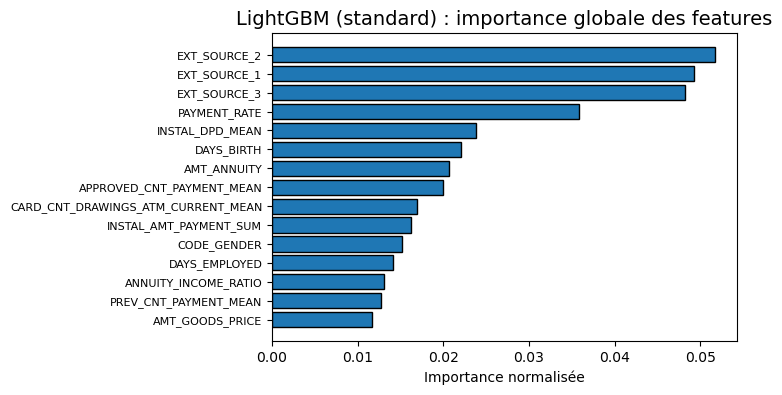

In [32]:
lgbm_feature_importances = pd.DataFrame({
        "feature" : list(processed_data["X_train"].columns),
        "importance" : lgbm_clf.feature_importances_
    })

title = "LightGBM (standard) : importance globale des features"
lgbm_feature_importances_sorted = plot_feature_importances(lgbm_feature_importances, 15, title)

In [40]:
def plot_shap_waterfall(classifier, X_test, row_index, title = None, max_display = 10) :

    explainer = shap.Explainer(classifier)
    shap_values = explainer(X_test)
    
    waterfall = shap.plots.waterfall(shap_values[row_index, :, 0], max_display = max_display, show = False)
    waterfall.set_size_inches(12, 8)
    
    if title is None :
        title = f"Importance des features pour la ligne {row_index}"
    
    plt.title(title, size = 20)
    plt.show()

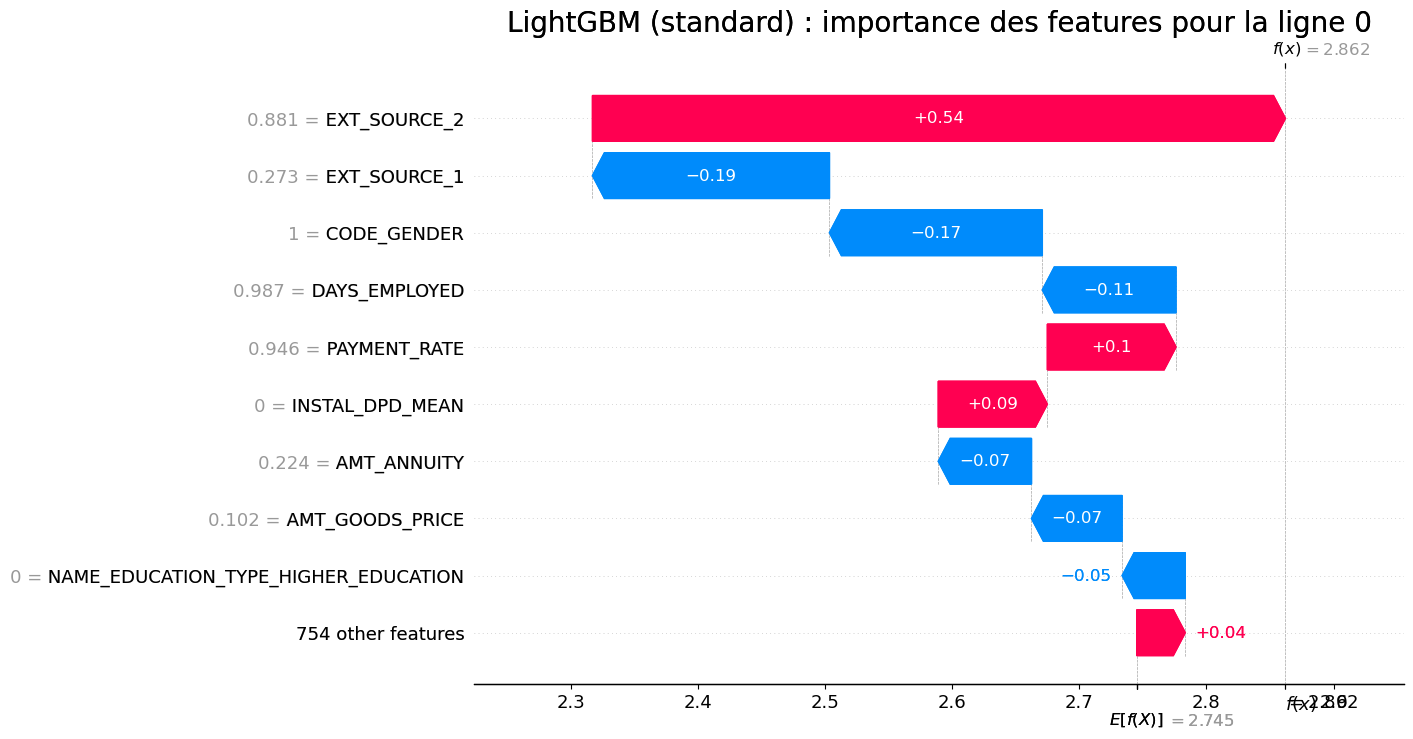

In [41]:
row_index = 0

title = f"LightGBM (standard) : importance des features pour la ligne {row_index}"
plot_shap_waterfall(lgbm_clf, processed_data["X_test"], row_index, title)

# Validation croisée

In [ ]:
def preprocess_folds(X, y, preprocessor, n_folds = 5, stratify = True, verbose = 1) :
    
    if stratify :
        folds = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 42)
    else :
        folds = KFold(n_splits = n_folds, shuffle = True, random_state = 42)
    
    folds_data = []
    
    for fold, (train_index, valid_index) in enumerate(folds.split(X, y)) :
        
        if verbose > 0 :
            print(f"Prétraitement du fold {fold + 1}/{n_folds}.")
            
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        data = preprocessor(X_train, X_valid, y_train, y_valid)
        folds_data.append(data)
    
    if verbose > 0 :
        print("Prétraitement terminé.")
    
    return folds_data

In [ ]:
def standard_preprocessor(X_train, X_valid, y_train, y_valid) :
    df_train = X_train.assign(**{"TARGET" : y_train})
    df_test = X_valid.assign(**{"TARGET" : y_valid})
    return preprocess_data(df_train, df_test, selected_features = X_train.columns)

def oversampling_preprocessor(X_train, X_valid, y_train, y_valid) :
    return preprocess_with_balancing(X_train, X_valid, y_train, y_valid, strategy = "over")

def undersampling_preprocessor(X_train, X_valid, y_train, y_valid) :
    return preprocess_with_balancing(X_train, X_valid, y_train, y_valid, strategy = "under")

def smote_preprocessor(X_train, X_valid, y_train, y_valid) :
    return preprocess_with_balancing(X_train, X_valid, y_train, y_valid, strategy = "smote")

In [ ]:
X = app_train.drop(columns = ["SK_ID_CURR", "TARGET"])
y = app_train["TARGET"].copy()

print("--- Prétraitement des folds (standard) ---")
folds_data_standard = preprocess_folds(X, y, standard_preprocessor)

print("--- Prétraitement des folds (oversampling) ---")
folds_data_over = preprocess_folds(X, y, oversampling_preprocessor)

print("--- Prétraitement des folds (undersampling) ---")
folds_data_under = preprocess_folds(X, y, undersampling_preprocessor)

print("--- Prétraitement des folds (SMOTE) ---")
folds_data_smote = preprocess_folds(X, y, smote_preprocessor)

del X, y

In [ ]:
def cross_validation(folds_data, classifier, verbose = 2) :
    
    scores = []
    
    for fold, data in enumerate(folds_data) :
        
        preds = apply_classifier(data, classifier)
        rge_train, rge_valid = evaluate_preds(data, preds, display_results = False)
        scores.append(rge_valid)

        if verbose > 1 :
            print("Score RGE sur le fold ", fold + 1, "/", len(folds_data), " : ", round(rge_valid, 5), sep = "")

    scores.insert(0, np.mean(scores))
    
    if verbose > 0 :
        print("Score RGE moyen : ", round(scores[0], 5))

    return scores

In [ ]:
print("--- Logistic Regression (standard preprocessing) ---")
cv_scores = cross_validation(folds_data_standard, LogisticRegression())

# Recherche d'hyperparamètres

In [ ]:
def generate_param_combinations(param_grid) :
    
    keys = param_grid.keys()
    values = param_grid.values()
    
    return [dict(zip(keys, value)) for value in product(*values)]

In [ ]:
def grid_search(folds_data, classifier_builder, param_grid, verbose = 1) :

    param_combinations = generate_param_combinations(param_grid)
    
    if verbose > 0 :
        print("Lancement de la grille de recherche sur", len(param_combinations), "jeux de paramètres.")

    best_score = float("-inf")
    best_params = None

    for step, params in enumerate(param_combinations) :
        
        if verbose > 0 :
            print("\nEtape ", step + 1, "/", len(param_combinations), sep = "")
        
        if verbose > 1 :
            print(params, sep = "")
        
        classifier = classifier_builder(params)
        scores = cross_validation(folds_data, classifier, verbose = 1)
        
        if scores[0] > best_score :
            best_params = params
            best_score = scores[0]
    
    if verbose > 0 :
        print("\nGrille de recherche terminée.")
        print("best_score :", best_score)
        print("best_params :", best_params)
            
    return best_params, best_score